<a href="https://colab.research.google.com/github/astopchatyy/GenAlgoTest/blob/basic_trainer/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from typing import Dict, List, Type, Iterator
from tqdm import tqdm
from abc import ABC, abstractmethod
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
import os
num_workers = os.cpu_count()
num_workers: int = num_workers if num_workers else 1
print("Number of workers:", num_workers)

Device: cuda
Number of workers: 12


In [2]:
from metric import Accuracy
from trainer import ShuffleTrainer, GeneticTrainer, BasePopulationTrainer

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ShuffleResBlock(BasicBlock):
    def __init__(self, planes, expansion=1):
        super().__init__(planes * expansion, planes, stride=1)
        self.expansion = expansion

class ShuffleResNet(nn.Module):
    def __init__(self, num_blocks: List[int], num_classes=10):
        super(ShuffleResNet, self).__init__()
        self.in_planes = 64
        self.block = BasicBlock
        self.shuffle_block_class = ShuffleResBlock

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(self.block, 128, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(self.block, 256, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(self.block, 512, num_blocks[2], stride=2)

        self.layer4 = self._make_shuffle_layer(ShuffleResBlock, 512, num_blocks[3], stride=1)
        self.layer5 = self._make_shuffle_layer(ShuffleResBlock, 512, num_blocks[4], stride=1)
        self.layer6 = self._make_shuffle_layer(ShuffleResBlock, 512, num_blocks[5], stride=1)


        self.linear = nn.Linear(512 * self.block.expansion, num_classes)

    def _make_layer(self, block: Type[BasicBlock], planes: int, num_blocks: int, stride: int):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride_val in strides:
            layers.append(block(self.in_planes, planes, stride_val))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _make_shuffle_layer(self, block: Type[ShuffleResBlock], planes: int, num_blocks: int, stride: int):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(planes))
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)

        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
class SimpleBlock(nn.Module):
    def __init__(self, in_c, out_c=None, dropout_rate=0.25, pool=True, batch_norm=True):
        super(SimpleBlock, self).__init__()
        if out_c is None:
            out_c = in_c
        self.in_c = in_c
        self.out_c = out_c
        self.conv = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.batch_norm_layer = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.pool = pool
        self.batch_norm = batch_norm
        self.pooling = nn.MaxPool2d(2, 2)


    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.batch_norm:
            x = self.batch_norm_layer(x)
        if self.pool:
            x = self.pooling(x)
        x = self.dropout(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self, batch_norm=True):
        super(SimpleCNN, self).__init__()
        self.batch_norm = batch_norm
        self.conv1 = SimpleBlock(3, 32, batch_norm=batch_norm)
        self.conv2 = SimpleBlock(32, 64, batch_norm=batch_norm)
        self.conv3 = SimpleBlock(64, 128, batch_norm=batch_norm)
        self.conv4 = SimpleBlock(128, 256, pool=False, batch_norm=batch_norm)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

base_train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

In [6]:
validation_fraction = 0.2
validation_size = int(len(testset) * validation_fraction)
seed = 42
g = torch.Generator().manual_seed(seed)
valset, trainset = torch.utils.data.random_split(base_train_set, [validation_size, len(base_train_set) - validation_size], generator=g)

val_loader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=num_workers)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=False, num_workers=num_workers)

In [ ]:
# pop_size = 1
# trainer = ShuffleTrainer(pop_size, ShuffleResNet, optim.Adam, nn.CrossEntropyLoss(), Accuracy(), [ShuffleResBlock], optimizer_params={"lr": 0.005}, model_params={"num_blocks": [1,1,1,1,1,1]})
# history = []

In [7]:
pop_size = 1
trainer = GeneticTrainer(pop_size, 0, SimpleCNN, optim.AdamW, nn.CrossEntropyLoss(), Accuracy(), scheduler_class=optim.lr_scheduler.CosineAnnealingLR, optimizer_params={"lr": 0.001}, scheduler_params={"T_max": 200})
history = []

In [64]:
history.append(trainer.train(1, train_loader, test_loader, val_loader, epoches_per_cycle=200, last_cycle_evolution=False, verbose=1))

KeyboardInterrupt: 

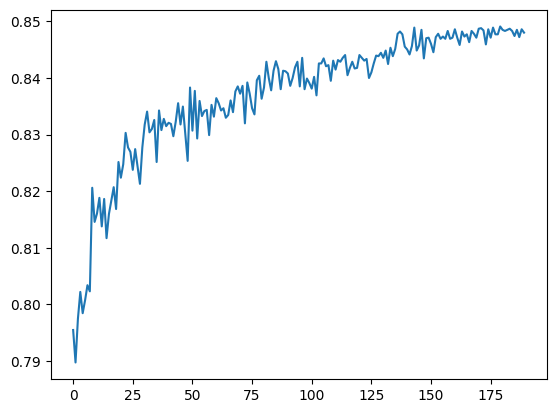

In [41]:
plt.plot(history[0]["test_metric"][0][0][10:])

In [8]:
pop_size2 = 8
trainer2 = GeneticTrainer(pop_size2, 0, SimpleCNN, optim.AdamW, nn.CrossEntropyLoss(), Accuracy(), scheduler_class=optim.lr_scheduler.CosineAnnealingLR, optimizer_params={"lr": 0.001}, scheduler_params={"T_max": 50})
history2 = []
h3 = []

In [10]:
for i in tqdm(range(50)):
  history2.append(trainer2.train(1, train_loader, test_loader, val_loader, epoches_per_cycle=1, last_cycle_evolution=False, verbose=0))
  h3.append(trainer2._evaluate_model(trainer2.extract_model(), test_loader))

100%|██████████| 50/50 [28:50<00:00, 34.60s/it]


In [15]:
h4 = []
for el in history2:
  h4.append(el["test_metric"][0][0][0])
h4

[0.6113528481012658,
 0.6587223101265823,
 0.7302215189873418,
 0.7321004746835443,
 0.7430775316455697,
 0.7626582278481012,
 0.7719541139240507,
 0.7628560126582279,
 0.7846123417721519,
 0.7860957278481012,
 0.7948971518987342,
 0.7995450949367089,
 0.7944026898734177,
 0.8052808544303798,
 0.8083465189873418,
 0.8126977848101266,
 0.8096321202531646,
 0.8182357594936709,
 0.8128955696202531,
 0.814181170886076,
 0.8132911392405063,
 0.8140822784810127,
 0.8161590189873418,
 0.8168512658227848,
 0.8203125,
 0.821004746835443,
 0.8243670886075949,
 0.8240704113924051,
 0.8248615506329114,
 0.8271360759493671,
 0.826443829113924,
 0.8262460443037974,
 0.828817246835443,
 0.8310917721518988,
 0.8303995253164557,
 0.8291139240506329,
 0.8299050632911392,
 0.8334651898734177,
 0.8301028481012658,
 0.8331685126582279,
 0.8325751582278481,
 0.8330696202531646,
 0.831190664556962,
 0.8308939873417721,
 0.8321795886075949,
 0.8336629746835443,
 0.8325751582278481,
 0.8348496835443038,
 0.832

In [31]:
m5 = extract_model(trainer2)

RuntimeError: self.size(-1) must be divisible by 2 to view Float as Long (different element sizes), but got 3

In [17]:
trainer2._evaluate_model(, test_loader)

0.8340585443037974

In [47]:
def extract_model(self, smilarity_fraction: float=0.8) -> nn.Module:
        mses = [[] for i in range(self._genetic_population_size)]
        for i in range(self._genetic_population_size):
          for j in range(i + 1, self._genetic_population_size):
            mses[i].append(self._layerwise_mse(self._population[i], self._population[j]))
            mses[j].append(self._layerwise_mse(self._population[i], self._population[j]))


        row_means = np.mean(mses, axis=1)
        selector = row_means <= np.quantile(row_means, smilarity_fraction)
        print(selector)
        avg_model = self._model_class(**self._model_params).to(self._device)
        avg_state = avg_model.state_dict()

        keys = avg_state.keys()
        for key in keys:
            stacked = torch.stack([self._population[i].state_dict()[key] for i in range(self._genetic_population_size) if selector[i]], dim=0)
            if stacked.dtype == torch.int64:
                avg_state[key] = stacked[0]
            else:
                avg_state[key] = stacked.mean(dim=0)

        avg_model.load_state_dict(avg_state)
        return avg_model

In [48]:
m3 = extract_model(trainer2)

[ True  True False False  True  True  True  True]


In [50]:
trainer2._layerwise_mse(m3, trainer2._population[1])

0.006462972145527601

In [41]:
m3.state_dict()["conv2.batch_norm.num_batches_tracked"]

tensor(18750, device='cuda:0')

In [59]:
m3.state_dict().keys()

odict_keys(['conv1.conv.weight', 'conv1.conv.bias', 'conv1.batch_norm.weight', 'conv1.batch_norm.bias', 'conv1.batch_norm.running_mean', 'conv1.batch_norm.running_var', 'conv1.batch_norm.num_batches_tracked', 'conv2.conv.weight', 'conv2.conv.bias', 'conv2.batch_norm.weight', 'conv2.batch_norm.bias', 'conv2.batch_norm.running_mean', 'conv2.batch_norm.running_var', 'conv2.batch_norm.num_batches_tracked', 'conv3.conv.weight', 'conv3.conv.bias', 'conv3.batch_norm.weight', 'conv3.batch_norm.bias', 'conv3.batch_norm.running_mean', 'conv3.batch_norm.running_var', 'conv3.batch_norm.num_batches_tracked', 'conv4.conv.weight', 'conv4.conv.bias', 'conv4.batch_norm.weight', 'conv4.batch_norm.bias', 'conv4.batch_norm.running_mean', 'conv4.batch_norm.running_var', 'conv4.batch_norm.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [68]:
key = "conv2.batch_norm.running_var"
mse = nn.functional.mse_loss(trainer2._population[0].state_dict()[key], trainer2._population[1].state_dict()[key]).item()
mse

3.1252801418304443

In [62]:
mse

0.014326607808470726

In [52]:
m3.state_dict()["conv2.batch_norm.running_mean"]

tensor([0.6665, 0.6470, 0.7929, 0.8207, 0.6608, 0.6926, 0.9556, 0.9189, 0.8021,
        0.9473, 0.8559, 0.8280, 0.7082, 0.7987, 0.6888, 0.8790, 0.7161, 0.7394,
        0.7188, 0.9128, 0.7329, 0.9266, 0.8647, 0.8413, 0.9968, 0.5274, 0.6907,
        0.8722, 0.6384, 0.7994, 0.6804, 0.6181, 1.0512, 1.1246, 0.8753, 0.7982,
        0.8225, 0.9535, 0.7498, 0.7786, 0.7918, 0.6911, 0.7761, 0.6649, 0.6033,
        0.8434, 0.7820, 0.9980, 0.7571, 0.6218, 0.8108, 0.7117, 0.6940, 0.7327,
        0.8405, 1.2721, 0.8613, 1.0525, 0.5773, 0.9034, 0.6870, 0.7139, 0.8765,
        0.8022], device='cuda:0')

In [51]:
trainer2._evaluate_model(trainer2._population[1], test_loader)

0.833564082278481

In [ ]:
max_vals = [0 for _ in range(pop_size)]
test_vals = [0 for _ in range(pop_size)]
for i in range(pop_size):
    for el in history[-1]["val_metric"][i]:
        for val in el:
            if val > max_vals[i]:
                max_vals[i] = val
                test_vals[i] = history[-1]["test_metric"][i][-1][-1]

print(max_vals)
print(max(max_vals))

print("====")
print(test_vals)
print(test_vals[np.argmax(max_vals)])

[0.8293945305049419]
0.8293945305049419
====
[0.8081487341772152]
0.8081487341772152


In [ ]:
model = trainer.extract_model(0.8)
trainer._evaluate_model(model, test_loader)

0.821993670886076

In [ ]:
for i in range(trainer._genetic_population_size):
  torch.save(trainer._population[i], f"/content/drive/MyDrive/gen_algo/4l/gen/model_4l_gen_{i}")

In [ ]:
for i in range(trainer._genetic_population_size):
  trainer._population[i] = torch.load(f"/content/drive/MyDrive/gen_algo/4l/gen/model_4l_gen_{i}", weights_only=False)

for i in range(trainer._superviser_population_size):
  trainer._population[trainer._genetic_population_size + i] = torch.load(f"/content/drive/MyDrive/gen_algo/4l/sep/model_4l_sep_{i}", weights_only=False)

In [ ]:
pops = []
for i in range(trainer._genetic_population_size):
  model = trainer._population[i]
  pops.append(model)

In [ ]:
for i in range(trainer._genetic_population_size):
  index_a, index_b = random.sample(range(len(pops)), 2)
  trainer._population[i] = trainer._crossover(pops[index_a], pops[index_b], mutation_chance=0.3)

In [ ]:
h = [[],[]]
h[0] = trainer.train(4, train_loader, test_loader, val_loader, epoches_per_cycle=1, last_cycle_evolution=False, mutation_chance=0.4)
h[1] = trainer.train(4, train_loader, test_loader, val_loader, epoches_per_cycle=1, last_cycle_evolution=False, mutation_chance=0)

In [ ]:
model = trainer.extract_model(1)
trainer._evaluate_model(model, test_loader)

0.8269382911392406

In [ ]:
model = trainer.extract_model(1)
trainer._evaluate_model(model, test_loader)

0.8267405063291139

In [ ]:
trainer2 = GeneticTrainer(1, 0, SimpleCNN, optim.Adam, nn.CrossEntropyLoss(), Accuracy(), optimizer_params={"lr": 0.001})
hh = trainer2.train(1, train_loader, test_loader, val_loader, epoches_per_cycle=200, last_cycle_evolution=False, mutation_chance=0)


In [ ]:
print(max(hh["val_metric"][0][0]), np.argmax(hh["val_metric"][0][0]), hh["test_metric"][0][0][np.argmax(hh["val_metric"][0][0])])

0.8433593772351742 195 0.8214003164556962


In [ ]:
[h[1]["test_metric"][i][-1] for i in range(len(h[1]["test_metric"]))]

[[0.8163568037974683],
 [0.8149723101265823],
 [0.8134889240506329],
 [0.811807753164557],
 [0.8158623417721519],
 [0.8145767405063291],
 [0.8084454113924051],
 [0.8166534810126582],
 [0.8089398734177216],
 [0.8143789556962026],
 [0.8137856012658228],
 [0.8194224683544303],
 [0.8082476265822784],
 [0.8157634493670886],
 [0.807060917721519],
 [0.806368670886076]]

In [ ]:
for i in range(trainer2._genetic_population_size):
  torch.save(trainer2._population[i], f"/content/drive/MyDrive/gen_algo/4l/sep/model_4l_sep_{i}")

In [ ]:
for i in range(trainer2._genetic_population_size):
  trainer2._population[i] = torch.load(f"/content/drive/MyDrive/gen_algo/4l/sep/model_4l_sep_{i}", weights_only=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.makedirs("/content/drive/MyDrive/gen_algo/4l/gen", exist_ok=True)
os.makedirs("/content/drive/MyDrive/gen_algo/4l/sep", exist_ok=True)